In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from torch import nn 
from tqdm import tqdm

In [3]:
from utils import *

In [4]:
arms = torch.tensor([[ 0.6667,  0.3333, -0.6667], [-0.2182,  0.8729, -0.4364]]).float()

In [5]:
bandit = GradientBandit(n_arms=2, context_size=2)
non_strat = Agents(n=1000, n_arms=2, context_size=2,
                  arms=arms,
                  max_reward=0, max_variance=0)

In [25]:
def pick_arm(y):
    y = np.maximum(0, np.sign(y))
    value = 0
    for i, v in enumerate(y):
        value += v * (2 ** i)
    return value

def color_picker(v):
    colors = ['red', 'green', 'blue', 'orange', 'yellow', 'purple', 'pink', 'black']
    return colors[v]

def train(model, dataset, learning_rate=1e-5, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    agent_rewards = dataset.rewards
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)
    
    for epoch in range(epochs):
        for xs, ys, variances in tqdm(data_loader):
            optimizer.zero_grad()
            loss = -model(x=xs, y=ys, variances=variances, agent_rewards=agent_rewards)
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            features = []
            predictions = []
            labels = []
            for xs, ys, variances in tqdm(data_loader):
                y_hat = model(x=xs, variances=variances, agent_rewards=agent_rewards)
                features += xs.numpy().tolist()
                predictions += [pick_arm(pred) for pred in y_hat]
                labels += [pick_arm(y) for y in ys]
            print('Error:', np.sum(predictions == labels).item() / len(labels))
            xs = [features[x][0] for x in range(len(features))]
            ys = [features[y][1] for y in range(len(features))]
            plt.scatter(xs, ys, c=[color_picker(int(v.item())) for v in predictions])
            plt.draw()

100%|██████████| 1000/1000 [00:00<00:00, 1037.97it/s]


Error: 0.0


100%|██████████| 1000/1000 [00:00<00:00, 1106.38it/s]


Error: 0.0


100%|██████████| 1000/1000 [00:00<00:00, 1053.65it/s]


Error: 0.0


100%|██████████| 1000/1000 [00:00<00:00, 1026.57it/s]


Error: 0.0


100%|██████████| 1000/1000 [00:00<00:00, 1049.60it/s]


Error: 0.0


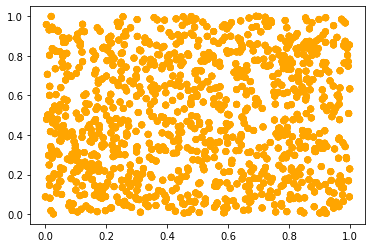

In [28]:
train(bandit, non_strat, learning_rate=0.5, epochs=5)

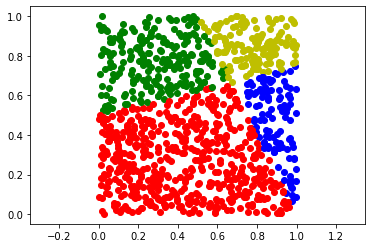

In [10]:
plt.axis('equal')
for i in range(len(non_strat)):
    x, y, var = non_strat[i]
    plt.scatter(x[0], x[1], c='r' if y[0] < 0 and y[1] < 0 else 'g' if y[0] < 0 and y[1] >= 0 else 'b' if y[0] >= 0 and y[1] < 0 else 'y')

In [ ]:
plt.axis('equal')
x_aug = torch.cat([non_strat.x, torch.ones(len(non_strat.x)).reshape(-1, 1)], 1).float()
ys = torch.max(x_aug @ arms.T, dim=-1).indices
for i in range(len(non_strat)):
    x, y, var = non_strat[i]
    plt.scatter(x[0], x[1], c='r' if ys[i] == 0 else 'b')